# 偏微分方程的数值解

庞龙刚@华中师范大学

## 学习内容

1. 偏微分方程的有限差分解法 (Finite Difference Method for Partial Differential Equations)
   - 迎风法 （Upwind）
   - 耗散与色散 （Dissipation and Dispersion）
   - 冯诺伊曼稳定性判据
2. 偏微分方程的有限体积解法
3. 偏微分方程的有限元解法

## 参考文献

1. 李新亮老师 PPT，[Bilibili视频](https://www.bilibili.com/video/av20283847/)
2. 计算流体力学教程，张德良编著（中国科学院研究生院教材）

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image

plt.style.use(['science', 'notebook', 'no-latex'])

## 什么是偏微分方程

偏微分方程是与常微分方程对立的概念。常微分方程中只包含函数对一个变量的导数，比如,

\begin{align}
{dy \over dt} = f(y, t)
\end{align}

而偏微分方程同时包含对多个变量的导数，比如相对论流体力学方程组（能动量守恒），

\begin{align}
\partial_{\mu} T^{\mu\nu} = 0
\end{align}

里面有对多个变量 $t, x, y, z$ 的偏导数，

\begin{align}
\partial_{t} T^{t\nu} + \partial_{x} T^{x\nu} + \partial_{y} T^{y\nu} + \partial_{z} T^{z\nu} = 0
\end{align}

其中能动量张量 $T^{\mu\nu} = (\varepsilon + P) u^{\mu}u^{\nu} - P g^{\mu\nu}$, $\epsilon$是能量密度，$P = P(\varepsilon)$ 是压强，由状态方程给出， $g^{\mu\nu} = {\rm diag}\{1, -1, -1, -1 \}$ 是度规张量。

$\nu=0， 1， 2， 3$ 对应四个偏微分方程。 $u^2 = u_{\mu}u^{\mu} = g_{\mu\nu} u^{\mu}u^{\nu} = 1$.

高能核物理中，为了描述夸克胶子等离子体火球的时空演化，我们需要，

1. 偏微分方程组（能动量守恒）

\begin{align}
\partial_{\mu} T^{\mu\nu} = 0
\end{align}

2. 初始条件 (初始时刻火球每一点的能量密度，压强，流速）

\begin{align}
 T^{\mu\nu}(t=0) = (\varepsilon_0 + P_0) u_0^{\mu}u_0^{\nu} - P_0 g^{\mu\nu}
\end{align}

3. 边界条件 （火球边界处的能量密度，流速等）

之后使用数值算法，求解每个时刻，QGP火球在空间每一点的能量密度和流速。

## 偏微分方程的几种数值解法

偏微分方程有很多种数值解法，比如
- 有限差分 Finite Difference
- 有限体积 Finite Volume
- 有限元 Finite Element
- 特征线法 Method of characteristics
- 光滑粒子近似 Smooth Particle 
- 格子玻尔兹曼 Lattice Boltzmann
- 无网格方法 Mesh Free Method
- ...

这门课只简单介绍前几种方法：

- 有限差分法：微分形式，对微分算子进行离散化近似
- 有限体积法：积分形式，只计算每个格子边界处的流入流出
- 有限元法：变分形式，对待求函数进行基函数展开近似
- 特征线法：偏微分方程化为常微分方程

有限差分和有限体积主要求解与时间有关的偏微分方程。

有限元主要求解与时间无关的偏微分方程。

## 一维偏微分方程，对流扩散问题，

为了研究不同数值算法求解复杂偏微分方程时的效果，一般先讨论最简单的一维情况下的对流扩散，

\begin{align}
{\partial \rho \over \partial t} + v {\partial  \rho \over \partial x} = D {\partial^2 \rho \over \partial x^2}
\end{align}

如果没有对流项 $v{\partial  \rho \over \partial x}$，方程描述的是在平静的湖面上滴一滴墨水，墨水如何扩散的问题；

如果有对流项，方程描述的是在流动的小溪中滴一滴墨水，墨水如何流动加扩散的问题。

偏微分方程的数值解算法可以在这个一维问题上进行测试，快速发现问题。

$\rho = \rho(t, x)$ 是时间 $t$ 和空间坐标 $x$ 的函数，要解此偏微分方程，需要提供一个**初始条件**，即 $t=t_0$ 时刻物质密度在坐标空间的分布，$\rho(t_0, x)$.

数值解上述偏微分方程，可以得到 $t_0 + h$, $t_0 + 2h$, $\cdots$, $t_0 + n h$ 离散时刻物质密度在空间的分布 $\rho(t_i, x)$, 其中 $h$ 是时间步长。

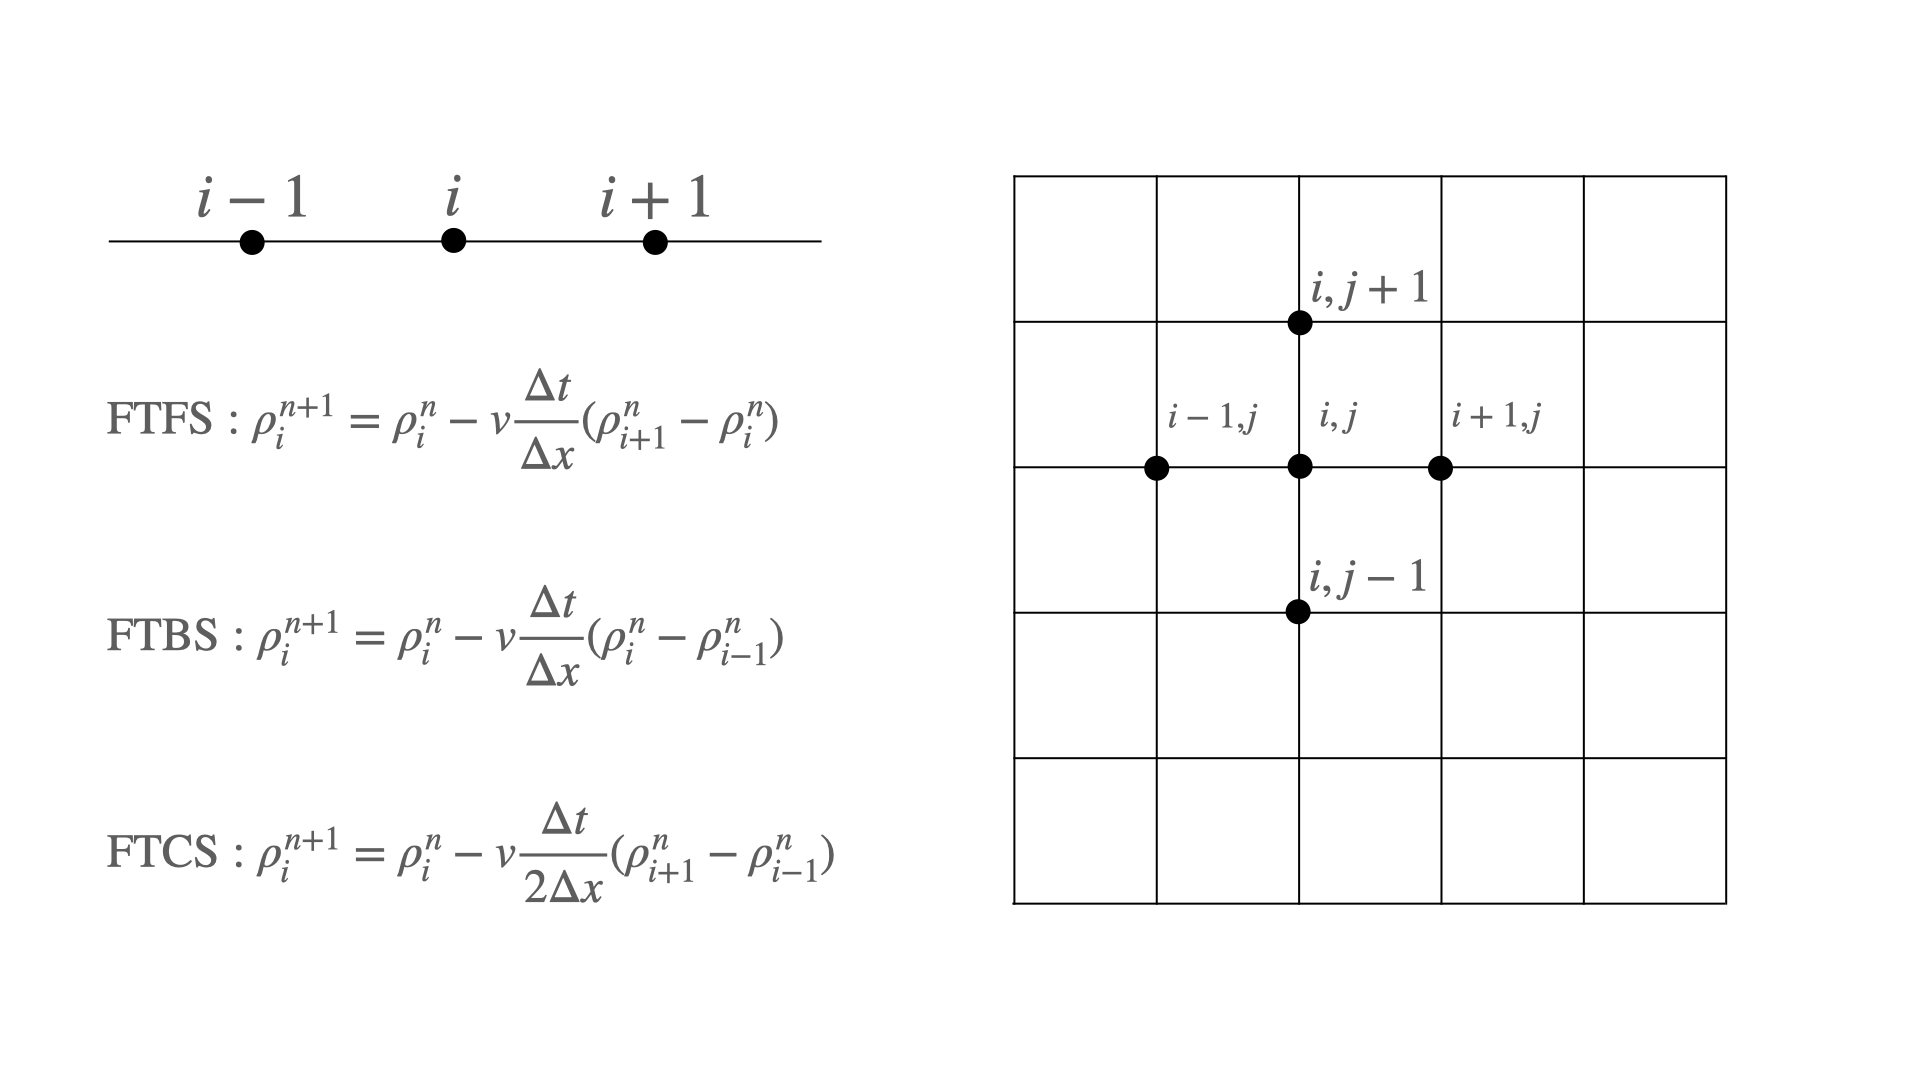

In [2]:
Image("images/finite_diff_grids.001.png")
# 除了时间离散化，一般还要对空间进行网格划分，
# 下面是 1 维与 2 维空间的网格化

网格划分之后，一个连续的函数 $\rho(t, x, y)$ 在 (t, x, y) 点的值可以写为离散的时间与空间网格上的值，

\begin{align}
\rho(t, x, y) = \rho(t_0 + n h, x_0 + i \Delta x, y_0 + j \Delta y) = \rho^n_{ij}
\end{align}

**如何做时间演化，得到下一时刻的 $\rho(t_0+h, x)$ 分布？**

考虑扩散项为零的情形。最简单的方法：有限差分法来近似微分

\begin{align}
{\rho^{n+1}_i - \rho^{n}_i \over h} + v {\rho^n_{i+1} - \rho^n_{i} \over \Delta x} = 0
\end{align}

其中 $\rho^n_i$ 的上标表示第 n 个时间步，下标表示第 i 个空间格子。移向得，

\begin{align}
\rho^{n+1}_i = \rho^{n}_i  -  { h v  \over \Delta x} (\rho^n_{i+1} - \rho^n_{i})
\end{align}

这种方法称为向前时间，向前空间差分法 **FTFS** (forward time forward space) 。

除此之外，还有向前时间，向后空间差分 (FTBS: forward time backward space)，

\begin{align}
\rho^{n+1}_i = \rho^{n}_i  -  { h v  \over \Delta x} (\rho^n_{i} - \rho^n_{i-1})
\end{align}

与向前时间，中心差分格式 (FTCS：Forward Time Central Space)，

\begin{align}
\rho^{n+1}_i = \rho^{n}_i  -  { h v  \over 2 \Delta x} (\rho^n_{i+1} - \rho^n_{i-1})
\end{align}

这么多不同的数值差分格式，该选哪一种？

### 迎风法 （Upwind algorithm）

数值上的微分章节提到在数值求解偏微分方程时，向前差分与向后差分不等价。

**迎风法（upwind method）**告诉我们，如果 $v>0$ 选向后差分，$v<0$选向前差分！

下面做个数值验证。

为了测试数值算法的稳定性，一般会人为设定一些极端的初始条件，比如初始物质分布是方波。

Text(0, 0.5, '$\\rho(x)$')

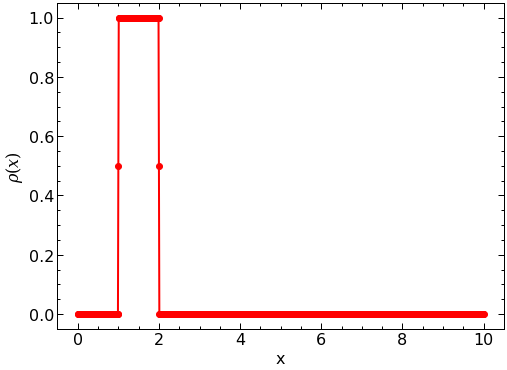

In [20]:
## 初始条件 rho(t0, x)
ngrid = 1001
xmin, xmax = 0, 10
velocity = 0.4

# 将空间离散化为 1000 个格子
x = np.linspace(xmin, xmax, ngrid, endpoint=True)
# 使用 heaviside 函数构造方波
rho0 = np.heaviside(x-1, 0.5) - np.heaviside(x-2, 0.5)

plt.plot(x, rho0, 'ro-')
plt.xlabel('x')
plt.ylabel(r'$\rho(x)$')

In [26]:
def FTFS(rho, v, x, h=0.001):
    '''
    :rho: rho(x), 1d array
    :v: velocity, float
    :x: 1d array, space grids
    :h: time step
    :return: rho^{n+1} at next step'''
    dx = x[1] - x[0]
    rho[:-1] = rho[:-1] - h * v / dx * (rho[1:] - rho[:-1])
    # 边界条件：最右边一个点使用常数外推边界条件
    rho[-1] = rho[-2]
    return rho

注意：这里我们使用了 numpy array 的整个数组相减操作.

如果一个数组有 n 个元素，$a[0], a[1], a[2], \cdots, a[n-1]$, 则 C 语言中的向前差分：

```CPP
double dadx[n-1]; 

for (int i=0; i < n-1; i++) {
    dadx[i] = (a[i+1] - a[i]) / dx;
}
```

对应 numpy 数组操作为，

```python
dadx = (a[1:] - a[:-1]) / dx
```

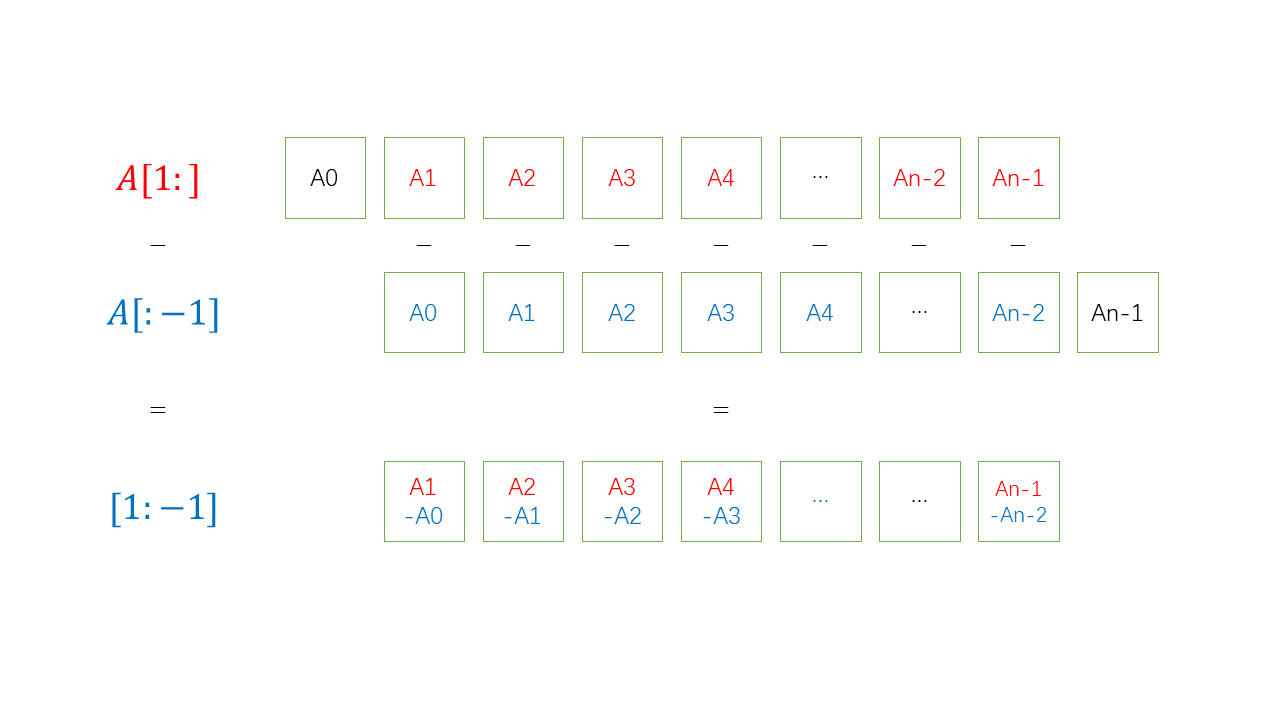

In [22]:
Image("images/finite_diff.pptx.png")

In [23]:
def visualize_evolve(rho0, velocity, method, x, h, nsteps=10):
    rho = np.copy(rho0)
    plt.plot(x, rho, 'k-', label='nt=0')
    for i in range(nsteps):
        rho = method(rho, velocity, x, h)
    plt.plot(x, rho, 'r--', label='nt=%s'%nsteps)
    plt.legend(loc='best')
    plt.xlabel('x')
    plt.ylabel(r'$\rho(x)$')

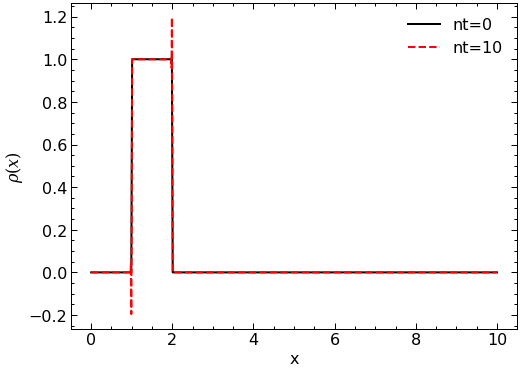

In [28]:
visualize_evolve(rho0, velocity, FTFS, x, h=0.001, nsteps=10)

In [29]:
## 迎风算法：速度 v > 0，使用后向差分，
##          速度 v < 0，使用前向差分
def upwind(rho, v, x, h=0.001):
    dx = x[1] - x[0]
    if v > 0: # rho[j] = rho[j] - v * r * (rho[j] - rho[j-1])
        rho[1:] = rho[1:] - h * v / dx * (rho[1:] - rho[:-1])
        rho[0] = rho[1]
    else:     # rho[j] = rho[j] - v * r * (rho[j+1] - rho[j])
        rho[:-1] = rho[:-1] - h * v / dx * (rho[1:] - rho[:-1])
        rho[-1] = rho[-2]
    
    return rho

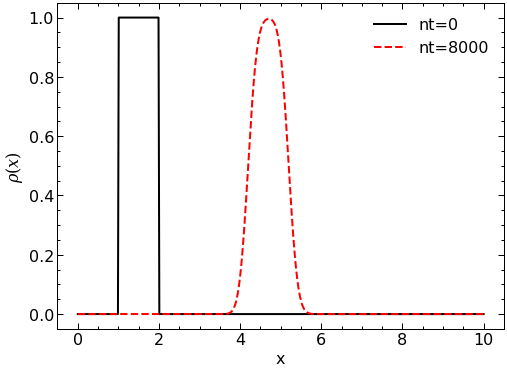

In [32]:
visualize_evolve(rho0, velocity, upwind, x, h=0.001, nsteps=8000)
# 可以看到迎风算法比随便构造出的数值差分算法稳定，尽管它有较大的耗散
# 解析解：向右移动到红色虚线的位置，但形状保持不变（方波）

结论：
1. $v>0$ 时使用 FTFS，很快出现震荡（色散）
2. 迎风算法比较稳定，可以成功演化到后期
3. 一阶迎风算法有耗散问题，长时演化方波变成了平滑波

解决方案：

1. 对空间部分，使用高阶差分算法，降低耗散
2. 对时间部分，使用Runge Kutta 算法，降低耗散
2. 使用单调算法，减小色散（震荡）

### 向前时间，中心空间差分算法 (Forward Time Central Space FTCS)

考虑第一种解决方案，对空间部分，使用二阶中心差分算法 （FTCS）算法，


\begin{align}
\rho^{n+1}_i = \rho^{n}_i  -  { h v  \over 2 \Delta x} (\rho^n_{i+1} - \rho^n_{i-1})
\end{align}


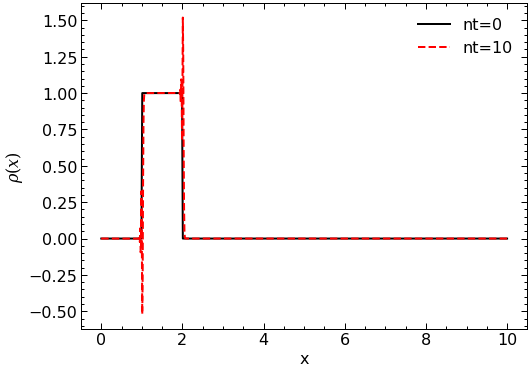

In [35]:
def FTCS(rho, v, x, h=0.001):
    dx = x[1] - x[0]
    rho[1:-1] = rho[1:-1] - 0.5 * h * v / dx * (rho[2:] - rho[:-2])
    rho[0] = rho[1]
    rho[-1] = rho[-2]
    return rho
# 此处可以改变 nsteps=10, 100, 800 观察长时间演化结果
visualize_evolve(rho0, velocity, FTCS, x, h=0.01, nsteps=10)

**FTCS** 算法失败！

从教科书上找一个常用的高阶差分算法，比如待求解方程，

\begin{align}
u_t + f_x = 0
\end{align}

对应的 “Lax-Wendroff" 二步差分格式为，

\begin{align}
u_{j + 1/2}^{n+1/2} &= {1 \over 2}(u_{j+1}^n + u_{j}^n) - {1 \over 2}{\Delta t \over \Delta x}(f_{j+1}^n - f_{j}^n)  \\
u_j^{n+1} &= u_j^n - {\Delta t \over \Delta x}(f_{j+1/2}^{n+1/2} - f_{j-1/2}^{n+1/2}) 
\end{align}

对应我们的问题，$u=\rho$, $f = v u$ 且 $v$ 为常数。

In [36]:
def lax_wendroff(rho, v, x, h=0.001):
        dx = x[1] - x[0]
        r = h / dx
        u = rho
        f = v * u
        # calc u_{j-1/2}^{n+1/2} and u_{j+1/2}^{n+1/2}
        uhalf = 0.5 * (u[1:] + u[:-1]) - 0.5 * r * (f[1:] - f[:-1])
        # calc f_{j-1/2} and f_{j+1/2}
        fjm = v * uhalf[:-1]
        fjp = v * uhalf[1:]
        u[1:-1] = u[1:-1] - r * (fjp - fjm)
        # set boundary condition
        u[-1] = u[-2]
        u[0] = u[1]
        return u

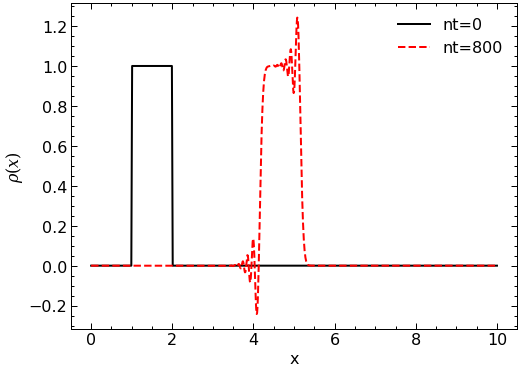

In [41]:
visualize_evolve(rho0, velocity, lax_wendroff, x, h=0.01, nsteps=800)
# Lax-Wendroff 算法格式耗散小，精度高，但是间断的上游会有数值振荡，下游振荡不明显
# 如果初始条件是平滑波，则结果会好很多


为何 Upwind 算法能够成功，而空间的一阶向前差分和二阶中心差分都发散？

是否有理论指导，能够判断一个偏微分方程的数值差分近似是否稳定？

就像哈密顿系统的辛几何算法所讲的，常微分方程离散格式的更新矩阵 $M$ 如果满足 $M^T J M = J$, 则保辛、稳定。

对于量子力学波函数的时间演化，如果时间演化矩阵幺正（保概率），则稳定。

对于偏微分方程，同样存在这样的判据。一般有**冯.诺伊曼方法**和**泰勒展开方法**，
估计数值差分格式的稳定性。

### 耗散与色散

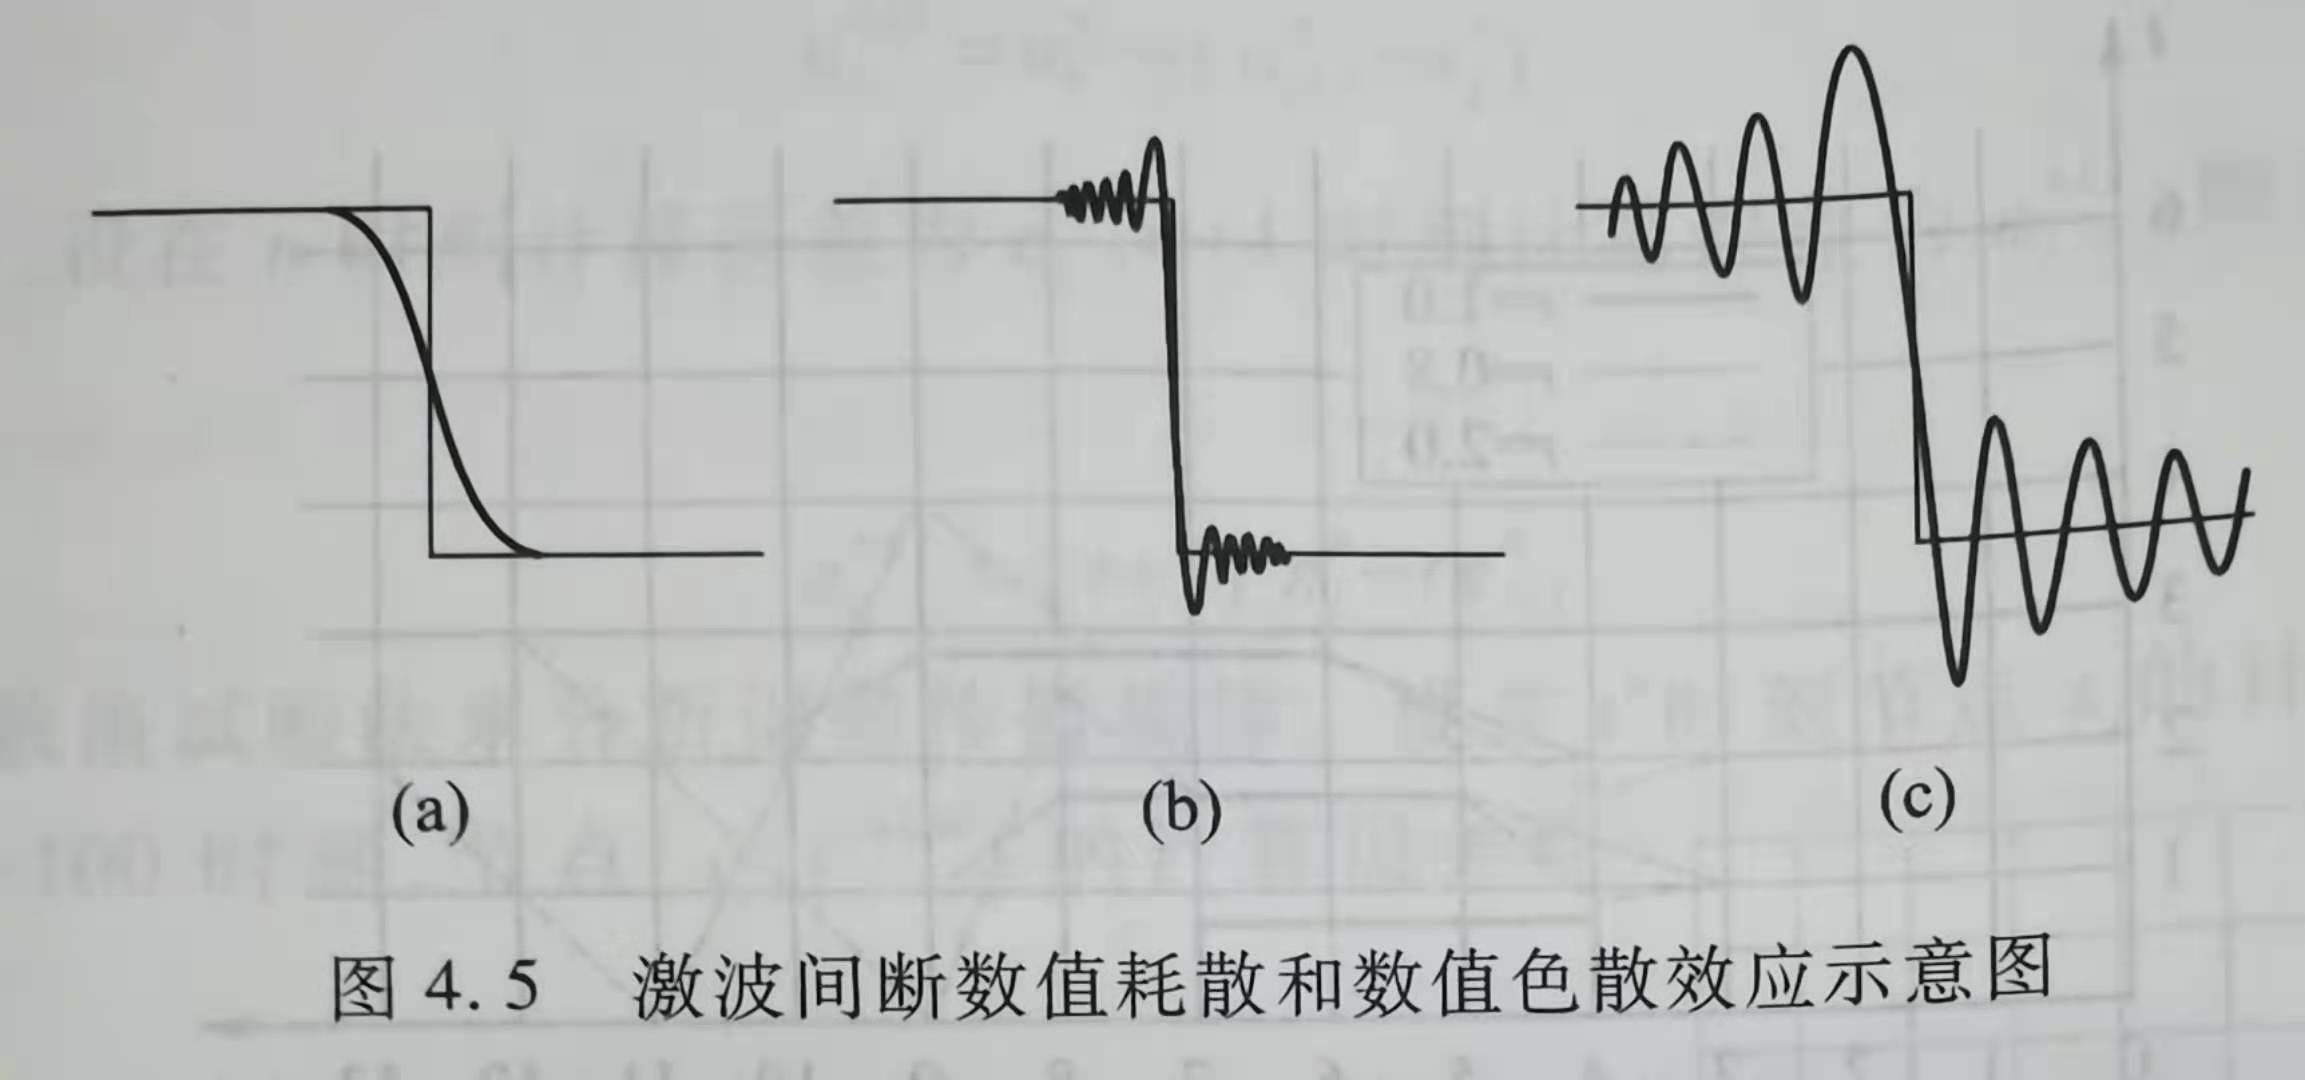

In [13]:
Image("images/dissipation_dispersion.jpg")
#(a): 耗散：差分导致的数值解被拉伸、幅度减小
#(b): 色散：差分导致的数值解在激波上下游出现高频振荡
#(c): 不稳定：振荡增大

**耗散**和**色散**都来自于截断误差

**耗散（Dissipation）** 来自于截断误差的偶数阶项

**色散（Dispersion）**来自截断误差的奇数阶项。

设偏微分方程的初始条件为，

\begin{align}
\rho(t=0, x) = \sum_k A_k e^{i k x}
\end{align}

其中，$k > 0$ 是波数，对流方程


\begin{align}
{\partial \rho \over \partial t} + v {\partial  \rho \over \partial x} = 0 
\end{align}

有解析解，

\begin{align}
\rho = \sum_k A_k e^{i k (x - vt)}
\end{align}

这是多个简谐波的叠加，波数 $k$ 对应的振幅为 $A_k$, 波速为 $v$。

如果初始条件是方波，则解析解中方波会整体以波速 $v$ 移动。


偏微分方程右边出现空间的偶数阶导数时，比如 2 阶和 4 阶空间微分，

\begin{align}
{\partial \rho \over \partial t} + v {\partial  \rho \over \partial x} = D_2 {\partial^2 \rho \over \partial x^2} + D_4 {\partial^4 \rho \over \partial x^4}
\end{align}

可以验证解析解为，

\begin{align}
\rho = \sum_k A_k e^{-D_2 k^2 t + D_4 k^4 t} e^{i k (x - vt)}
\end{align}

此时，只有振幅发生改变，为 $A_k e^{-D_2 k^2 t + D_4 k^4 t}$, 对应耗散（Dissipation）。

偏微分方程右边出现空间的奇数阶导数时，比如 3 阶和 5 阶空间微分，

\begin{align}
{\partial \rho \over \partial t} + v {\partial  \rho \over \partial x} = D_3 {\partial^3 \rho \over \partial x^3} + D_5 {\partial^5 \rho \over \partial x^5}
\end{align}

可以验证解析解为，

\begin{align}
\rho = \sum_k A_k e^{i k \left(x - (v + D_3 k^3 t - D_5 k^5) t\right)}
\end{align}

此时，只有相位发生改变（与虚数 i 有关的项），新的波速为 $v' = v + D_3 k^3 t - D_5 k^5$, 依赖于 k。

不同的波数 $k$ 对应不同的波速，这对应**色散**（Dispersion）

### 利用“修正方程”判断差分格式的耗散与色散

差分方程是对偏微分方程的近似，它们并不一定逼近原偏微分方程。

差分方程逼近的偏微分方程称为**修正方程**（Modified PDE), 

下面看如何得到一个差分格式的修正方程，以 FTBS 格式为例，

\begin{align}
\rho^{n+1}_i = \rho^{n}_i  -  { v\Delta t  \over \Delta x} (\rho^n_{i} - \rho^n_{i-1})
\end{align}

设 $r = { v\Delta t  \over \Delta x} $, 对上述方程在 $x_i$ 的临域做泰勒展开，


\begin{align}
\rho^{n+1}_i = \rho^{n}_i + \Delta t \left( {\partial \rho \over \partial t}\right)_i^n + {\Delta t^2 \over 2} \left( {\partial^2 \rho \over \partial t^2}\right)_i^n + {\Delta t^3 \over 6} \left( {\partial^3 \rho \over \partial t^3}\right)_i^n + \cdots \\
\rho^{n}_{i-1} = \rho^{n}_i - \Delta x \left( {\partial \rho \over \partial x}\right)_i^n + {\Delta x^2 \over 2} \left( {\partial^2 \rho \over \partial x^2}\right)_i^n - {\Delta x^3 \over 6} \left( {\partial^3 \rho \over \partial x^3}\right)_i^n + \cdots \\
\end{align}

将泰勒展开式子代入差分方程，得到

\begin{align}
+ \Delta t \left( {\partial \rho \over \partial t}\right)_i^n + {\Delta t^2 \over 2} \left( {\partial^2 \rho \over \partial t^2}\right)_i^n + {\Delta t^3 \over 6} \left( {\partial^3 \rho \over \partial t^3}\right)_i^n + \cdots = r \left( - \Delta x \left( {\partial \rho \over \partial x}\right)_i^n + {\Delta x^2 \over 2} \left( {\partial^2 \rho \over \partial x^2}\right)_i^n - {\Delta x^3 \over 6} \left( {\partial^3 \rho \over \partial x^3}\right)_i^n + \cdots \right)
\end{align}

简化为，

\begin{align}
{\partial \rho \over \partial t} + v  {\partial \rho \over \partial x} = -{\Delta t \over 2}  {\partial^2 \rho \over \partial t^2} - {\Delta t^2 \over 6}  {\partial^3 \rho \over \partial t^3} + \cdots + v \left( { \Delta x \over 2}{\partial^2 \rho \over \partial x^2} - { \Delta x^2 \over 6}  {\partial^3 \rho \over \partial x^3} + \cdots \right)
\end{align}

时间的高阶导数项可以用上式通过自循环的方法替换掉，右边只保留空间的高阶导数项，即得到差分方程表示的**修正方程**。注意：不能使用原始的偏微分方程消掉右边时间的高阶项！通过这种方式，得到对流方程各种差分格式的“修正方程”，

\begin{align}
{\rm FTBS}: \ {\partial \rho \over \partial t} + v  {\partial \rho \over \partial x} &= {v \over 2} \Delta x ( 1 - r) \rho_{xx} + {v \over 6} \Delta x^2 ( -2 r^2 + 3 r - 1) \rho_{xxx} + \cdots \\
{\rm FTFS}: \ {\partial \rho \over \partial t} + v  {\partial \rho \over \partial x} &= {v \over 2} \Delta x ( 1 + r) \rho_{xx} + {v \over 6} \Delta x^2 ( -2 r^2 + 3 r - 1) \rho_{xxx} + \cdots \\
{\rm Lax-Wendroff}: \ {\partial \rho \over \partial t} + v  {\partial \rho \over \partial x} &= -{v  \Delta x^2\over 6} ( 1 - r^2) \rho_{xxx} - {v\Delta x^2 \over 8}  r(1- r^2 ) \rho_{xxxx} + \cdots
\end{align}

观察对空间的偶数与奇数阶微分，即可分析差分格式的色散与耗散。

## 冯$\cdot$诺伊曼稳定性分析

使用 Fourier 展开，计算对任一个波数 k，差分格式中误差的放大倍数，从而判断格式是否稳定。

比如，对流方程的 FTCS 差分格式，

\begin{align}
\rho^{n+1}_i = \rho^{n}_i  -  { h v  \over 2 \Delta x} (\rho^n_{i+1} - \rho^n_{i-1})
\end{align}

其各项的 Fourier 分解为，

\begin{align}
\rho_{j}^n &= \sum_k \hat{\rho}_j^n e^{i jk \Delta x} \\
\rho_{j\pm 1}^n &= \sum_k \hat{\rho}_j^n e^{i (j\pm 1) k \Delta x} 
\end{align}

其中 $i^2 = -1$, $\hat{\rho}_j^n$ 是波数为 k 的分量 $\hat{\rho}(k, t_{n})$，与 x 无关。代入差分方程得到每个分量的误差方程，


\begin{align}
\hat{\rho}_{j}^{n+1} &= \hat{\rho}_j^n \left( 1 - i r \sin k\Delta x\right)
\end{align}

即对第 k 个分波，误差放大倍数为

\begin{align}
G \equiv {\hat{\rho}_{j}^{n+1} \over \hat{\rho}_j^n } = \left( 1 - i r \sin k\Delta x\right)
\end{align}

要保证 G 有界，需要 $|G|\le 1$ 对所有 $k\Delta x$ 都满足。

当 $\sin k\Delta x \neq 0$ 时， FTCS 格式 $|G| = \sqrt{1 + r^2 \sin^2 k\Delta x} \gt 1$。因此 FTCS 格式**恒不稳定**。

同理得到 FTBS 格式的放大因子的绝对值为，(练习）


\begin{align}
|G| = \sqrt{ 1 - 4 r (1 - r) \sin^2 \left(k \Delta x \over 2 \right)^2}
\end{align}

对于 $v>0$, $r = {v \Delta t \over \Delta x}$, 因为 $4 r \sin^2 \left(k \Delta x \over 2 \right)^2$ 恒大于 0，

所以，只要 $1 - r > 0$, 则 FTBS 格式稳定。

即 FTBS 格式的稳定条件为 $r = {v \Delta t \over \Delta x} \le 1$ 时差分格式稳定，这对应 CFL 条件 $v \Delta t \le \Delta x$.

**所以，FTBS 格式的稳定是有条件的！冯$\cdot$诺伊曼判据可以告诉我们这个条件。**

## 特征线法 (Method of characteristics)

特征线法可以得到一些简单线性或准线性偏微分方程的解析解。

它的思路是：既然我们要得到全时空上的场量 $\rho(t, x)$，我们可以考虑将二维时空离散化为很多一维的线，

\begin{align}
t = t(s) \\
x = x(s)
\end{align}

场量沿着这些线的微分表示为，

\begin{align}
{d \rho \over d s } = {\partial \rho \over \partial t} {d t  \over d s} +  {\partial  \rho \over \partial x} {d x  \over d s}
\end{align}

设 

\begin{align}
{d t  \over d s} &= 1， \; t(s=0)=0 \\
{d x  \over d s} &= v, \; x(s=0)=\zeta \\
{d \rho \over ds} &= 0, \; \rho(s=0)=\rho(t=0, x=\zeta)
\end{align}

我们得到了一族曲线 $(t(s), x(s))$, 在这族曲线上，偏微分方程可以化简为常微分方程，

\begin{align}
{d \rho \over ds} = {\partial \rho \over \partial t} + v {\partial  \rho \over \partial x} = 0 
\end{align}

这族曲线 $ x = v t + \zeta$ 称为**特征线**, $\zeta$ 是截距（特征线与 t=0 轴的交点）， $v$ 是斜率。

沿着特征线，方程的解为常数，即 $\rho(t, x) = \rho(t-t, x-at) = \rho(0, \zeta)$。

对于任一点 (t, x), 可以沿着特征线回溯到起点 $(t-t, x-at) = (0, \zeta)$.

虽然之前我们说对流方程的解析解为：方波按速度 v 随时间移动。

使用特征线法，我们得到了这个解析解。

特征线法可以应用于高维线性和准线性偏微分方程。

## 有限体积法

\begin{align}
\int_{V_{P}} \underbrace{\frac{\partial \rho \phi}{\partial t} d V}_{\text {temporal derivative }}+\int_{V_{P}} \underbrace{\nabla \cdot(\rho \mathbf{u} \phi) d V}_{\text {convective term }}-\int_{V_{P}} \underbrace{\nabla \cdot\left(\rho \Gamma_{\phi} \nabla \phi\right) d V}_{\text {diffusion term }}=\int_{V_{P}} \underbrace{S_{\phi}(\phi) d V}_{\text {source term }}
\end{align}

一个控制体积中物质的量的改变等于下面几项的总和

1. 对流项：流入流出
2. 扩散项：扩散出
3. 源项：Source or Sink

如果偏微分方程中有散度项 $\nabla$，则根据高斯定理，体积分可以写为边界处的面积分。

比如，简单的三维连续性方程，

\begin{align}
\frac{\partial \rho}{\partial t}+\frac{\partial(\rho u)}{\partial x}+\frac{\partial(\rho v)}{\partial y}+\frac{\partial(\rho w)}{\partial z}=0
\end{align}

写成积分形式为，

\begin{align}
\frac{\partial}{\partial t} \int_{V} \rho d V+\int_{S} \rho \mathbf{u} \cdot d \mathbf{S}=0
\end{align}

其中 $V$ 是控制体(Control Volume), $S$ 是控制表面(Control surface)，$\mathbf{u} = (u, v, w)$ 是三维速度向量。$\mathbf{S}$ 是表面法向量。

相对论流体力学的数值解程序很多都使用有限体积算法，比如 MUSIC，CLVisc 使用了 Kurganov–Tadmor (KT) 算法，

\begin{align}
\partial_{\tau} Q+\partial_{x} F^{x}+\partial_{y} F^{y}+\partial_{\eta_{s}} F^{\eta_{s}}=S
\end{align}

其中 $Q$ 是守恒量，$F^{x, y, \eta_s}$ 是沿三个方向的流 Flux, $S$ 是源项 Source Term。

不考虑源项的话，上述偏微分方程写成积分形式为，

\begin{align}
\begin{aligned} \frac{d \bar{Q}_{i, j, k}}{d \tau}=&-\frac{H_{i+1 / 2, j, k}^{x}-H_{i-1 / 2, j, k}^{x}}{d x} \\ &-\frac{H_{i, j+1 / 2, k}^{y}-H_{i, j-1 / 2, k}^{y}}{d y}-\frac{H_{i, j, k+1 / 2}^{\eta_{s}}-H_{i, j, k-1 / 2}^{\eta_{s}}}{\tau d \eta_{s}} \end{aligned}
\end{align}

其中 $\bar{Q}_{ijk}$ 表示第 (i,j,k) 个 Control Volume 中守恒量的均值，它等于对控制体积分，再除以单位体积。

沿 x 方向边界处的面积分，等于边界处的流入流出量之和乘以面积 dydz, 再除以单位体积，最终分母上多出一个 dx。

边界处的流一般使用黎曼解（解析解）得到，此处不做详述。

## 有限元法 （Finite Element Method）

有限元法是一种非常流行的求解时间无关的偏微分方程的数值算法。

被广泛应用于结构受力分析，复杂边界的麦克斯韦方程求解以及热传导等问题。

在工程、固体力学、弹塑性力学、电磁学、热传导等多个方面有广泛的应用场景。

之前讲到，我们国家的冯康院士独立于西方发展出了有限元算法，
这一节简单介绍一下有限元方法。

### 加权残差法（Weighted Residual Method ）

理解了加权残差法，有限元算法就理解了一半。
这里使用参考文献

Advanced Electromagnetic Computation，Dikshitulu K. Kalluri

中的例子，介绍加权残差法，为有限元算法筑基。

举例：求解 x(t) , 使其满足如下微分方程，
\begin{align}
{dx \over dt } + x = 0 
\end{align}

初始条件 $x(0)=1$, 求解区域 $t \in [0, 1]$ 。
这个方程的解析解是 $e^{-t}$ ,

\begin{align}
x(t) = e^{-t} = 1 - t + {1 \over 2!}t^2  - {1 \over 3!}t^3  + {1 \over 4!}t^4 + \cdots  
\end{align}

在计算机上展开到无穷阶，就能给出方程的精确解。现实中显然只能考虑有限项，后面忽略的项称作截断误差。假设截断到二阶，

\begin{align}
x(t) \approx 1 - t + {1 \over 2!}t^2   
\end{align}

代入原方程产生残差 R ，

\begin{align}
{dx \over dt } + x = R, \; R\neq 0 
\end{align}

R 越接近0，表示近似解越接近精确解。
明知道精确解 $e^{-t}$ 不在 $(1, t, t^2)$ 这三个函数支撑起的函数空间中，我们仍可做出改进。
使用待定系数展开，

\begin{align}
x(t) \approx 1 + c_1 t + c_2 t^2 
\end{align}

此时残差函数为，

\begin{align}
R(t) = {d x\over dt} + x(t) = 1 + (1 +t)c_1 + (2 t + t^2) c_2 
\end{align}

通过调节 $c_1,c_2$ , 最小化 R(t) 的绝对值，就能得到比 $1 - t + {1 \over 2!}t^2$ 更好的解。

最优情况显然是 $R(t)$  对任意 t  都等于零，但这个做不到。所以存在不同的方法，减弱约束。

下面介绍四种方法，
- 点匹配法：在有限个点上，要求 R(t) 等于0
- 子区域法：在有限子域上，要求 R(t) 均值等于0
- 伽辽金法：对有限检验函数，要求 R(t) 的加权求和等于0
- 最小二乘法：通过求 $\int_0^1R^2(t)dt$ 的最小值，解待定系数

### 点匹配法 (Point Matching)

最简单的考虑是，既然有 $c_1,c_2$ 两个待定系数，那我们只需要任选两个点，让 R(t) 在那两个点上等于 0，就可以得到两个方程，刚好可求解出 $c_1,c_2$，
比如，选 t =1/3，2/3 两个点，得到两个方程。对第一个方程，
\begin{align}
R\left({1 \over 3} \right) = 1 + c_1\left(1 + {1 \over 3}\right) + c_2\left(2 \times {1\over 3}+ ({1\over 3})^2 \right) = 0 
\end{align}

化简得到，
\begin{align}
{4 \over 3}c_1 + {7 \over 9} c_2 = -1 
\end{align}

同理，对 t   = 2/3 , 得到方程，

\begin{align}
{5 \over 3}c_1 + {16 \over 9} c_2 = -1
\end{align}

解出 $c_1=-0.9310,\; c_2=0.3103 $，所以近似解为

\begin{align}
x(t) \approx 1 - 0.9310\ t + 0.3103\ t^2   
\end{align}


### 子域法（Subdomain method）

根据待定系数的个数 n，将求解区域分成 n 份，要求 R(t) 在每份上的积分等于0。

对于这个例子，分 $ t \in [0, 1/2] 和 t \in [1/2, 1]$ 两个子域，求解如下两个方程，

\begin{align}
\int_0^{1/2} R(t) dt = 0,\quad\; \int_{1/2} ^{1}R(t) dt = 0 
\end{align}

即可得到近似解，


\begin{align}
x(t) \approx 1 - 0.9474\ t + 0.3158\ t^2  
\end{align}

### 伽辽金法（Galerkin method）
如果 $R(t)=0$ 对于任意 t 都成立，显然 $\phi(t)R(t)=0$ 应该对任意检验函数 $\phi(t)$ 成立。

根据待定系数个数 n，选取 n 个不同的检验函数 $\phi_i(t),\ 1 \le i \le n$ , 要求对每个 $\phi_i$ , 下式满足

\begin{align}
\int_0^1\phi_i(t)R(t) dt = 0 
\end{align}

这样，就构造了 n 个方程，刚好可解 n 个待定系数。
检验函数的一种自然选择是 x(t) 展开时使用的基底函数 ${1, t, t^2}$ ,  求解

\begin{align}
\int_0^1 t R(t) dt = 0,\quad\; \int_0^1 t^2 R(t) dt = 0
\end{align}

得到近似解，

\begin{align}
x(t) \approx 1 - 0.9143\ t + 0.2857\ t^2   
\end{align}

### 最小二乘法 （Least Square Method）

函数极值处一阶导数等于0。求残差平方 $R^2(t)$ 积分的最小值，可以得到待定系数满足的方程，

\begin{align}
\frac{\partial}{\partial c_{1}} \int_{0}^{1} R^{2}(t) \mathrm{d} t=2 \int_{0}^{1} \frac{\partial R}{\partial c_{1}} R(t) \mathrm{d} t=0 
\end{align}

对于 $c_1, c_2$ 分别求导数，得到两个方程，

\begin{align}
\int_{0}^{1} \frac{\partial R}{\partial c_{1}} R \mathrm{~d} t=\frac{3}{2}+\frac{7}{3} c_{1}+\frac{9}{4} c_{2}=0 \\ \int_{0}^{1} \frac{\partial R}{\partial c_{2}} R \mathrm{~d} t=\frac{4}{3}+\frac{9}{4} c_{1}+\frac{38}{15} c_{2}=0  
\end{align}

求解可得近似解，
\begin{align}
x(t) \approx 1 - 0.9427\ t + 0.3110\ t^2  
\end{align}

这四种方法可以用一个统一的式子描述，这个式子跟 Galerkin 给出的式子基本一致，

\begin{align}
\int_{0}^{1} w_{j}(t) R(t) \mathrm{d} t=0, \quad j=1,2 
\end{align}

上述参考文献总结了这四种方法对应的检验函数，如下所示，

<img src="images/finite_element_galerkin.png"></img>

### 有限元法与有限差分法的区别，

一般的微分方程都可以写成 $L f(x) = 0$ 形式，其中 $L$  称为微分算子（Differential Operator)。有限差分和有限元的区别在于有限差分对微分算子进行离散化近似，有限元对待求解函数进行基函数展开近似。
\begin{align}
\underbrace{\rm Differential\ Operator}_{\rm finite\ difference} \underbrace{f(x)}_{\rm finite \ element}=0
\end{align}

有限差分算法(finite difference) 用有限差分来近似微分算子，比如一阶微分，

\begin{align}
{df \over dx} \approx {f(x+\Delta x) - f(x - \Delta x ) \over 2\Delta x}
\end{align}

有限元算法（finite element) 用子域上的基函数展开来近似想要求解的方程 f(x),

\begin{align}
f(x) = \sum_{k=1}^n a_k \phi_k(x)
\end{align}

这是一种求基函数展开系数的变分法。

### Galerkin 有限元算法

有限元算法的导出可以使用 （1）Galerkin 方法 （2） 变分法。

这里我们使用 Galerkin 有限元算法，中文翻译“伽辽金”法。

假设要求解的微分方程有统一的格式，

\begin{align}
{\mathcal L} \phi(x) = f(x) 
\end{align}

其中 $\mathcal L$ 是微分算子， $\phi$ 是要求解的场，f 是源。

将 $\phi$  做函数基底展开 (使用爱因斯坦求和规则，省略 $\sum_{j=0}^n$ 求和符号），

\begin{align}
\phi(x) = \sum_{j=1}^{n} \phi_j u_j(x) = \phi_j u_j(x) 
\end{align}

注意此时 $u_j(x)$ 为基底函数，人工设定，为已知量，$\phi_j$ 为待定系数。

选取基底函数 $u_i(x)$ 作为伽辽金法中的检验函数，则对第 i 个检验函数，加权残差为，
\begin{align}
R_i  =  \int_{\Omega}u_i  ({\mathcal L} u_j \phi_j -f) d\Omega =  K_{ij} \phi_j -b_i  
\end{align}

其中 $\Omega$ 是全域，

\begin{align}
K_{ij} &= \int_{\Omega} u_i {\mathcal L} u_j d\Omega \equiv \langle u_i | {\mathcal L} u_j \rangle , \\
b_{i} &= \int_{\Omega} u_i fd\Omega \equiv  \langle u_i |f\rangle 
\end{align}



可以将 $R_i = K_{ij} \phi_j - b_i$ 写成矩阵乘积形式，此处用 $|\cdot \rangle$ 表示列向量，
\begin{align}
|R \rangle = K |\phi\rangle - |b\rangle  
\end{align}

K 是 $K_{ij}$ 构成的矩阵， $|\phi\rangle$ 是 ${\phi_j}$ 构成的列向量， $|b\rangle$ 是 b_i 构成的列向量。

Galerkin 有限元法令残差 $|R\rangle$ 为0，通过解 $K |\phi\rangle = |b\rangle$ ，得到待定系数  $|\phi\rangle$ 。

### 分片基底函数展开

将全域离散化为 n 个子域，每个子域称作一个单元（“element”）。

连续的函数 $\phi(x)$ 近似为有限个单元上的分片函数。如果单元很小，每个单元内 $\phi(x)$ 近似线性变化。

先考虑简单的一维问题，将区间分成 n 等份，每份长 h 。

对第 e 个单元区域 $x \in [x_{j-1}, x_j]$ ，线性插值函数为

\begin{align}
\phi(x) = \phi_{j-1}(1 - r) + \phi_j r 
\end{align}

其中 $r = {x - x_{j-1} \over x_j - x_{j-1}  } $ ，

当 $x = x_{j-1}$  时， r = 0 , $\phi(x) = \phi_{j-1} $

当 $x \rightarrow x_{j}$  时， $r = 1 , \phi(x) = \phi_{j}$

根据 $\phi(x) = \sum_j \phi_j u_j(x)$ 的定义，得到第 j 个基底函数（注意它横跨两个单元），

\begin{align}
u_j(x) = \left\{\begin{array} {ll}  (x - x_{j-1}) /h  \quad\; {\rm for}\quad\; x \in [x_{j-1}, x_j] \\  (x_{j+1} - x) /h  \quad\; {\rm for}\quad\; x \in [x_{j}, x_{j+1}] \\  0 \quad\;\quad\;\quad\quad\quad\ \ \; {\rm otherwise} \end{array} \right. 
\end{align}

$u_j(x)$ 的函数图像就是下图中间那个大三角形，覆盖第 j 和第 j+1 个单元。它跟 $u_{j-1}(x)$ 在第 j 个单元有重叠，跟 $u_{j+1}(x)$ 在第 j+1 个单元有重叠。此时内积都是局部进行，不重叠区域积分为0。

根据 $K_{ij} =\int_{\Omega} u_i {\mathcal L} u_j d\Omega$  可知第 j 行只有 $K_{j,j-1} , K_{jj} , K_{j, j+1}$ 三个非零矩阵元，K 矩阵是稀疏的 3 对角阵。

<img src="images/finite_element_basis1d.png"></img>

### 二阶微分算子降阶

算 $K_{ij}$ 时，很快遇到第一个问题，线性插值函数一阶微分在每个单元内为常数，

\begin{align}
\partial_x u_j(x) = \left\{\begin{array} {ll}  1/h  \quad\;\;\;\ {\rm for}\quad\; x \in [x_{j-1}, x_j] \\  -1/h  \quad\; {\rm for}\quad\; x \in [x_{j}, x_{j+1}] \\  0 \quad\;\quad\;\ \; {\rm otherwise} \end{array} \right. 
\end{align}

二阶或更高阶导数等于0。如果微分算子里有二阶导数，可以用分部积分法降阶，

\begin{align}
\int A {dB \over dx} dx = \int A dB = AB- \int B dA = AB - \int B {dA \over dx}  dx 
\end{align}

二阶微分算子降阶之后变为，

\begin{align}
K_{ij} = \int_{\Omega} u_i \partial_{xx} u_j dx = u_i \partial_x u_j |_{x_{min}}^{xmax} - \int_{\Omega}(\partial_x u_i) (\partial_x u_j) dx 
\end{align}

$u_i \partial_x u_j |_{xmin}^{xmax}$ 只与全域边界条件有关，对于大部分不在边界上的点，这项为0。刚好在边界上的那些点， $\phi_j$ 或它的导数已知，因此可以将这一项单独列出来，令

\begin{align}
g_i = \left( u_i \partial_x u_j|_{\rm xmax} - u_i \partial_x u_j |_{\rm xmin} \right) \phi_j 
K_{ij} = - \int_{\Omega}(\partial_x u_i) (\partial_x u_j) dx = - \langle \partial_x u_i | \partial_x u_j \rangle 
\end{align}


在新的定义下，方程变为，

\begin{align}
 K |\phi\rangle = |b\rangle  - |g\rangle 
\end{align}

多出来的那项 $|g\rangle$ 是分部积分项在边界处的贡献 $g_i$ 构成的列向量。
此时矩阵K 第 j 行的非零矩阵元为,

\begin{align}
K_{j, j-1}= -\langle \partial_x u_{j} | \partial_{x} u_{j-1} \rangle = 1/h \\
K_{j,j}= - \langle \partial_x u_{j} | \partial_{x} u_j \rangle = -2/h \\
K_{j,j+1}= -\langle \partial_x u_{j} | \partial_{x} u_{j+1} \rangle = 1/h 
\end{align}

每个矩阵元的积分区间由前面的示意图给出。
注意此时 $\partial_x u_k$ 或者等于 1/h，或者等于 -1/h，积分很好算。

## 使用有限元求解简单的泊松方程

我们已经有了足够的知识，从头构造一个简单的一维 Galerkin 有限元算

有限元方法求解步骤总结如下，
1. 将全域离散化为有限个子域（又称单元）
2. 选择基底函数，对每个子域插值
3. 用 Galerkin 法改写微分方程，函数内积计算 $K, |b\rangle$ 的矩阵元
4. 解  $K |\phi\rangle = |b\rangle - |g\rangle$

这里拿一个简单的一维泊松方程演示伽辽金有限元算法。

**物理问题**：根据 Maxwell 方程，电场的散度正比于电荷密度 $\epsilon_0 \nabla \cdot \vec{E} = \rho$，而电场本身又可写成标量势 $\phi$ 的负梯度 $\vec{E} = -\nabla \phi$, 其中 $\nabla =\left \{\partial_x, \partial_y, \partial_z \right\}$ 。

将第二个方程代入第一个得到给定电荷分布下静电势满足的柏松方程， $\nabla^2 \phi = -\rho / \epsilon_0$ ，

二维情况下方程为，

\begin{align}
（{d^2  \over dx^2} + {d^2  \over dy^2}）\phi(x, y) =  -\rho(x, y) / \epsilon_0 ，
\end{align}

一维情况下

\begin{align}
{d^2  \over dx^2}\phi(x) =  -\rho(x) / \epsilon_0 
\end{align}

其中 $\epsilon_0$  是真空电极化常数。
选择求解区域 $x \in [0, 1]$，边界条件 $\phi(0) = \phi(1) = 0$。
选择一个简单的电荷密度分布，
$\rho(x) = \epsilon_0 \sin(\pi x)$

此时，泊松方程有简单的解析解： $\phi(x) = \sin(\pi x)/\pi^2$, 我们先假装不知道。

计算 $|b\rangle$的矩阵元，

\begin{align}
b_j &= -{1\over \epsilon_0} \int_0^1 \rho(x) u_j(x) dx \\
&=-{1\over \pi h}(x_{j-1} + x_{j+1} - 2x_j)\cos\pi x_{j} \\ 
&- {1\over \pi^2h}(2\sin\pi x_{j} - \sin\pi x_{j-1} - \sin\pi x_{j+1}) 
\end{align}

这个积分用手积挺容易出错，写一小段 python 代码，将积分区域划分为 $[x_{j-1}, x_j] 与 [x_j, x_{j+1}]$ 进行积分。

In [42]:
import sympy

xjm1, xj, xjp1 = sympy.symbols(['x_{j-1}', 'x_{j}', 'x_{j+1}'])
x, h, eps = sympy.symbols(['x', 'h', '\epsilon'])
rho = lambda x: sympy.sin(sympy.pi * x)

A = - sympy.integrate(rho(x) * (x - xjm1)/h, (x, xjm1, xj))
B = - sympy.integrate(rho(x) * (xjp1 - x)/h, (x, xj, xjp1))

sympy.simplify(A + B)

(pi*(-x_{j+1} + x_{j})*cos(pi*x_{j}) + pi*(-x_{j-1} + x_{j})*cos(pi*x_{j}) + sin(pi*x_{j+1}) + sin(pi*x_{j-1}) - 2*sin(pi*x_{j}))/(pi**2*h)

Jackson 电动力学书本中介绍了一种简化方法，假设 $\rho(x)$ 在每个单元里是常数，只对 $u_j(x)$ 积分，则积分结果为，

\begin{align}
|b\rangle = -h \sin(\pi x) 
\end{align}

先不管 $|g\rangle$ , 矩阵方程的解为， $|\phi\rangle = K^{-1} |b\rangle$ 。写一段简单的 python 代码，构造矩阵 K  和列向量 $|b\rangle$ ，使用 scipy.sparse.linalg.inv 函数求 K  的逆，进而得到结果。

In [43]:
from scipy.sparse import dia_matrix
from scipy.sparse.linalg import inv
from numpy import pi

class FEM:
    def __init__(self, nodes, xmin=0, xmax=1):
        self.nodes = nodes
        x = np.linspace(xmin, xmax, nodes)
        self.x = x
        self.h = x[1] - x[0]
        
    def Kmatrix(self):
        n = self.nodes
        m = 1/self.h * np.ones(n)
        data = [m, -2*m, m]
        offsets = [-1, 0, 1]
        # 使用 scipy.sparse 稀疏矩阵库，构造 3 对角稀疏矩阵 K
        K = dia_matrix((data, offsets), shape=(n, n)).tocsc()
        return K
    
    def bvec(self):
        '''假设 rho(x) 在每个单元内值为常数，仅对 u_j(x) 做积分'''
        return - np.sin(pi * self.x) * self.h
    
    def solve(self):
        K = self.Kmatrix()
        b = self.bvec()
        return inv(K) * b
    
    def compare(self):
        ground_truth = 1/(pi**2) * np.sin(pi * self.x)
        fem_res = self.solve()
        
        plt.plot(self.x, ground_truth, 'k-', label="ground truth")
        plt.plot(self.x, fem_res, 'r--', label="finite element")
        plt.title("number of nodes = %s"%self.nodes)
        plt.xlabel("x")
        plt.ylabel(r"$\phi(x)$")
        plt.legend(loc='best')
        plt.show()

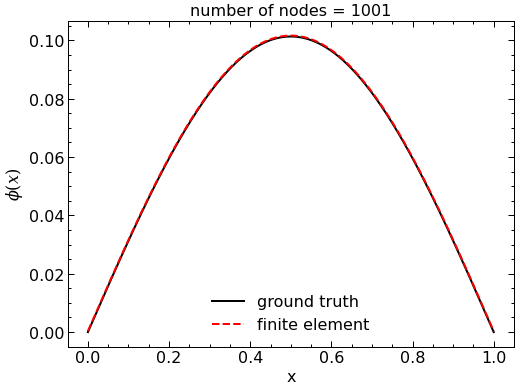

In [16]:
fem = FEM(1001)
fem.compare() 

## 总结

简单介绍了偏微分方程数值解的有限差分、有限体积与有限元算法。

每个方向都是一个非常大的研究领域，如果在以后的学习、科研中用到这些方法，可以本节课为入门知识，进一步学习。